In [59]:
# Load generated recipes files
import pandas as pd

# Load the data
manual = pd.read_json('../data/generated_recipes_manual_review.json', dtype={'correct': 'boolean'})
rag = pd.read_json('../data/generated_recipes_rag_review.json', dtype={'correct': 'boolean'})
moderator = pd.read_json('../data/generated_recipes_moderator_review.json', dtype={'correct': 'boolean'})
combined = pd.read_json('../data/generated_recipes_combined_review.json', dtype={'correct': 'boolean'})

rag.rename(columns={'correct': 'correct_rag'}, inplace=True)
moderator.rename(columns={'correct': 'correct_moderator'}, inplace=True)
combined.rename(columns={'correct': 'correct_combined'}, inplace=True)
totalset = pd.merge(manual, rag[['medische_vraag', 'correct_rag']], on='medische_vraag', how='left')
totalset = pd.merge(totalset, moderator[['medische_vraag', 'correct_moderator']], on='medische_vraag', how='left')
totalset = pd.merge(totalset, combined[['medische_vraag', 'correct_combined']], on='medische_vraag', how='left')

# Totaal aantal vragen
totaal_vragen = totalset.shape[0]

# Aantal correcte antwoorden
correct_counts = totalset[['correct', 'correct_rag', 'correct_moderator', 'correct_combined']].sum()

# False positives (FP) en false negatives (FN) berekeningen
false_positives_rag = totalset[(totalset['correct'] == False) & (totalset['correct_rag'] == True)].shape[0]
false_negatives_rag = totalset[(totalset['correct'] == True) & (totalset['correct_rag'] == False)].shape[0]

false_positives_moderator = totalset[(totalset['correct'] == False) & (totalset['correct_moderator'] == True)].shape[0]
false_negatives_moderator = totalset[(totalset['correct'] == True) & (totalset['correct_moderator'] == False)].shape[0]

false_positives_combined = totalset[(totalset['correct'] == False) & (totalset['correct_combined'] == True)].shape[0]
false_negatives_combined = totalset[(totalset['correct'] == True) & (totalset['correct_combined'] == False)].shape[0]

# Totaal fouten (FP + FN)
totaal_fouten_rag = false_positives_rag + false_negatives_rag
totaal_fouten_moderator = false_positives_moderator + false_negatives_moderator
totaal_fouten_combined = false_positives_combined + false_negatives_combined

totaal_vragen_check_rag = correct_counts['correct_rag'] + totaal_fouten_rag
totaal_vragen_check_moderator = correct_counts['correct_moderator'] + totaal_fouten_moderator
totaal_vragen_check_combined = correct_counts['correct_combined'] + totaal_fouten_combined

# Print alle resultaten
print(f"Totaal aantal vragen: {totaal_vragen}")
print("\nCorrecte antwoorden:")
print(correct_counts)

print("\nFalse positives en false negatives:")
print(
    f"RAG -> False positives: {false_positives_rag}, False negatives: {false_negatives_rag}, Totaal fouten: {totaal_fouten_rag}")
print(
    f"Moderator -> False positives: {false_positives_moderator}, False negatives: {false_negatives_moderator}, Totaal fouten: {totaal_fouten_moderator}")
print(
    f"Combined -> False positives: {false_positives_combined}, False negatives: {false_negatives_combined}, Totaal fouten: {totaal_fouten_combined}")

print("\nControleren dat alles optelt tot totaal:")
print(f"RAG -> Correct + Fouten: {totaal_vragen_check_rag} (Verwacht: {totaal_vragen})")
print(f"Moderator -> Correct + Fouten: {totaal_vragen_check_moderator} (Verwacht: {totaal_vragen})")
print(f"Combined -> Correct + Fouten: {totaal_vragen_check_combined} (Verwacht: {totaal_vragen})")

print("BELANGRIJK")
# Vragen die niet in RAG voorkomen
missing_in_rag = manual[~manual['medische_vraag'].isin(rag['medische_vraag'])]
print("Vragen in 'manual' maar niet in 'rag':")
print(missing_in_rag['medische_vraag'])

# Vragen die niet in MODERATOR voorkomen
missing_in_moderator = manual[~manual['medische_vraag'].isin(moderator['medische_vraag'])]
print("\nVragen in 'manual' maar niet in 'moderator':")
print(missing_in_moderator['medische_vraag'])

# Vragen die niet in COMBINED voorkomen
missing_in_combined = manual[~manual['medische_vraag'].isin(combined['medische_vraag'])]
print("\nVragen in 'manual' maar niet in 'combined':")
print(missing_in_combined['medische_vraag'])

# Vragen in RAG maar niet in MODERATOR
rag_not_in_moderator = rag[~rag['medische_vraag'].isin(moderator['medische_vraag'])]
print("Vragen in 'rag' maar niet in 'moderator':")
print(rag_not_in_moderator['medische_vraag'])

# Vragen in MODERATOR maar niet in RAG
moderator_not_in_rag = moderator[~moderator['medische_vraag'].isin(rag['medische_vraag'])]
print("\nVragen in 'moderator' maar niet in 'rag':")
print(moderator_not_in_rag['medische_vraag'])

# Vragen in RAG maar niet in COMBINED
rag_not_in_combined = rag[~rag['medische_vraag'].isin(combined['medische_vraag'])]
print("\nVragen in 'rag' maar niet in 'combined':")
print(rag_not_in_combined['medische_vraag'])

# Vragen in COMBINED maar niet in RAG
combined_not_in_rag = combined[~combined['medische_vraag'].isin(rag['medische_vraag'])]
print("\nVragen in 'combined' maar niet in 'rag':")
print(combined_not_in_rag['medische_vraag'])

# Vragen in MODERATOR maar niet in COMBINED
moderator_not_in_combined = moderator[~moderator['medische_vraag'].isin(combined['medische_vraag'])]
print("\nVragen in 'moderator' maar niet in 'combined':")
print(moderator_not_in_combined['medische_vraag'])

# Vragen in COMBINED maar niet in MODERATOR
combined_not_in_moderator = combined[~combined['medische_vraag'].isin(moderator['medische_vraag'])]
print("\nVragen in 'combined' maar niet in 'moderator':")
print(combined_not_in_moderator['medische_vraag'])

print("")
print("")
print("")


print("BELANGRIJK UNIEKE VRAGEN EN MANUAL REVIEWS KOMEN NIET OVEREEN MBT MEDISCHE VRAGEN")
print("BELANGRIJK UNIEKE VRAGEN EN MANUAL REVIEWS KOMEN NIET OVEREEN MBT MEDISCHE VRAGEN")
print("BELANGRIJK UNIEKE VRAGEN EN MANUAL REVIEWS KOMEN NIET OVEREEN MBT MEDISCHE VRAGEN")

print("")
print("")
print("")
import json

# Laad data uit beide bestanden
with open('../data/unieke_vragen.json', 'r', encoding='utf-8') as f1:
    unieke_vragen = json.load(f1)

with open('../data/generated_recipes_manual_review.json', 'r', encoding='utf-8') as f2:
    manual_reviews = json.load(f2)

# Extract 'vraag' en 'medische_vraag' uit beide bestanden
unieke_vragen_set = {item['vraag'].strip().lower() for item in unieke_vragen}
manual_vragen_set = {item['medische_vraag'].strip().lower() for item in manual_reviews}

# 1. Vragen die in unieke_vragen.json zitten maar niet in manual_reviews.json
vragen_in_unieke_niet_in_manual = unieke_vragen_set - manual_vragen_set
print(f"Aantal vragen in 'unieke_vragen.json' maar niet in 'manual_reviews.json': {len(vragen_in_unieke_niet_in_manual)}")
print("Vragen in 'unieke_vragen.json' maar niet in 'manual_reviews.json':")
print(vragen_in_unieke_niet_in_manual)

# 2. Vragen die in manual_reviews.json zitten maar niet in unieke_vragen.json
vragen_in_manual_niet_in_unieke = manual_vragen_set - unieke_vragen_set
print(f"\nAantal vragen in 'manual_reviews.json' maar niet in 'unieke_vragen.json': {len(vragen_in_manual_niet_in_unieke)}")
print("Vragen in 'manual_reviews.json' maar niet in 'unieke_vragen.json':")
print(vragen_in_manual_niet_in_unieke)

# 3. Gemeenschappelijke vragen in beide bestanden
gemeenschappelijke_vragen = unieke_vragen_set & manual_vragen_set
print(f"\nAantal gemeenschappelijke vragen in beide bestanden: {len(gemeenschappelijke_vragen)}")
print("Gemeenschappelijke vragen in beide bestanden:")
print(gemeenschappelijke_vragen)



Totaal aantal vragen: 199

Correcte antwoorden:
correct              140
correct_rag          141
correct_moderator    181
correct_combined     132
dtype: Int64

False positives en false negatives:
RAG -> False positives: 31, False negatives: 29, Totaal fouten: 60
Moderator -> False positives: 49, False negatives: 7, Totaal fouten: 56
Combined -> False positives: 28, False negatives: 35, Totaal fouten: 63

Controleren dat alles optelt tot totaal:
RAG -> Correct + Fouten: 201 (Verwacht: 199)
Moderator -> Correct + Fouten: 237 (Verwacht: 199)
Combined -> Correct + Fouten: 195 (Verwacht: 199)
BELANGRIJK
Vragen in 'manual' maar niet in 'rag':
95     Ik wil anticonceptie gebruiken. Ik wil pillen ...
164    Ik heb zwangerschapsdiabetes. Welke behandelop...
Name: medische_vraag, dtype: object

Vragen in 'manual' maar niet in 'moderator':
95     Ik wil anticonceptie gebruiken. Ik wil pillen ...
164    Ik heb zwangerschapsdiabetes. Welke behandelop...
Name: medische_vraag, dtype: object

Vragen

In [55]:
print# Count the number of correct answers
correct_counts = totalset[['correct', 'correct_rag', 'correct_moderator', 'correct_combined']].sum()
# Print the counts
print("Number of correct answers:")
print(correct_counts)

false_positives_rag = totalset[(totalset['correct'] == False) & (totalset['correct_rag'] == True)][
    'medische_vraag'].count()
false_positives_moderator = totalset[(totalset['correct'] == False) & (totalset['correct_moderator'] == True)][
    'medische_vraag'].count()
false_positives_combined = totalset[(totalset['correct'] == False) & (totalset['correct_combined'] == True)][
    'medische_vraag'].count()

print(f"Number of false positives rag: {false_positives_rag}")
print(f"Number of false positives moderator: {false_positives_moderator}")
print(f"Number of false positives combined: {false_positives_combined}")

false_negatives_rag = totalset[(totalset['correct'] == True) & (totalset['correct_rag'] == False)][
    'medische_vraag'].count()
false_negatives_moderator = totalset[(totalset['correct'] == True) & (totalset['correct_moderator'] == False)][
    'medische_vraag'].count()
false_negatives_combined = totalset[(totalset['correct'] == True) & (totalset['correct_combined'] == False)][
    'medische_vraag'].count()
print(f"Number of false negatives rag: {false_negatives_rag}")
print(f"Number of false negatives moderator: {false_negatives_moderator}")
print(f"Number of false negatives combined: {false_negatives_combined}")

precision_rag = correct_counts['correct_rag'] / (correct_counts['correct_rag'] + false_positives_rag) if (
                                                                                                                 correct_counts[
                                                                                                                     'correct_rag'] + false_positives_rag) > 0 else 0
recall_rag = correct_counts['correct_rag'] / (correct_counts['correct_rag'] + false_negatives_rag) if (correct_counts[
                                                                                                           'correct_rag'] + false_negatives_rag) > 0 else 0
precision_moderator = correct_counts['correct_moderator'] / (
        correct_counts['correct_moderator'] + false_positives_moderator) if (correct_counts[
                                                                                 'correct_moderator'] + false_positives_moderator) > 0 else 0
recall_moderator = correct_counts['correct_moderator'] / (
        correct_counts['correct_moderator'] + false_negatives_moderator) if (correct_counts[
                                                                                 'correct_moderator'] + false_negatives_moderator) > 0 else 0
precision_combined = correct_counts['correct_combined'] / (
        correct_counts['correct_combined'] + false_positives_combined) if (correct_counts[
                                                                               'correct_combined'] + false_positives_combined) > 0 else 0
recall_combined = correct_counts['correct_combined'] / (
        correct_counts['correct_combined'] + false_negatives_combined) if (correct_counts[
                                                                               'correct_combined'] + false_negatives_combined) > 0 else 0

print(f"Precision rag: {precision_rag:.2f} Recall rag: {recall_rag:.2f}")
print(f"Precision moderator: {precision_moderator:.2f} Recall moderator: {recall_moderator:.2f}")
print(f"Precision combined: {precision_combined:.2f} Recall combined: {recall_combined:.2f}")

print("#########################")
print("#########################")
print("#########################")
print("#########################")

# False positives: Laat 'correct', 'correct_rag' en 'medische_vraag' zien
false_positives_rag = totalset[
    (totalset['correct'] == False) & (totalset['correct_rag'] == True)
    ][['correct', 'correct_rag', 'medische_vraag']]

# False negatives: Laat 'correct', 'correct_rag' en 'medische_vraag' zien
false_negatives_rag = totalset[
    (totalset['correct'] == True) & (totalset['correct_rag'] == False)
    ][['correct', 'correct_rag', 'medische_vraag']]

# Correcte voorspellingen: Waar correct en correct_rag overeenkomen
correct_predictions_rag = totalset[
    totalset['correct'] == totalset['correct_rag']
    ][['correct', 'correct_rag', 'medische_vraag']]

# Print de waarden voor false positives
print("False positives van RAG (met correcte waarde en voorspelling):")
print(false_positives_rag)

# Print de waarden voor false negatives
print("\nFalse negatives van RAG (met correcte waarde en voorspelling):")
print(false_negatives_rag)

# Print de waarden voor correcte voorspellingen
print("\nCorrecte voorspellingen van RAG:")
print(correct_predictions_rag)

# False positives: Laat 'correct', 'correct_moderator' en 'medische_vraag' zien
false_positives_moderator = totalset[
    (totalset['correct'] == False) & (totalset['correct_moderator'] == True)
    ][['correct', 'correct_moderator', 'medische_vraag']]

false_positives_combined = totalset[
    (totalset['correct'] == False) & (totalset['correct_combined'] == True)
    ][['correct', 'correct_combined', 'medische_vraag']]

# False negatives: Laat 'correct', 'correct_moderator' en 'medische_vraag' zien
false_negatives_moderator = totalset[
    (totalset['correct'] == True) & (totalset['correct_moderator'] == False)
    ][['correct', 'correct_moderator', 'medische_vraag']]

false_negatives_combined = totalset[
    (totalset['correct'] == True) & (totalset['correct_combined'] == False)
    ][['correct', 'correct_combined', 'medische_vraag']]

# Correcte voorspellingen: Waar correct en correct_moderator overeenkomen
correct_predictions_moderator = totalset[
    totalset['correct'] == totalset['correct_moderator']
    ][['correct', 'correct_moderator', 'medische_vraag']]

# Correcte voorspellingen: Waar correct en correct_combined overeenkomen
correct_predictions_combined = totalset[
    totalset['correct'] == totalset['correct_combined']
    ][['correct', 'correct_combined', 'medische_vraag']]

# Print resultaten
print("False positives van moderator:")
print(false_positives_moderator)

print("\nFalse negatives van moderator:")
print(false_negatives_moderator)

print("\nCorrecte voorspellingen van moderator:")
print(correct_predictions_moderator)

print("\n#########################")

print("\nFalse positives van combined:")
print(false_positives_combined)

print("\nFalse negatives van combined:")
print(false_negatives_combined)

print("\nCorrecte voorspellingen van combined:")
print(correct_predictions_combined)

print("#########################")
print("#########################")
print("FALSE POSITIVES")
print("#########################")

# False positives: 'medische_vraag' voor beide datasets
false_positives_rag_set = set(
    totalset[
        (totalset['correct'] == False) & (totalset['correct_rag'] == True)
        ]['medische_vraag']
)

false_positives_moderator_set = set(
    totalset[
        (totalset['correct'] == False) & (totalset['correct_moderator'] == True)
        ]['medische_vraag']
)

# Overlapping tussen false positives van RAG en moderator
overlapping_false_positives = false_positives_rag_set & false_positives_moderator_set
# False positives in RAG maar niet in moderator
false_positives_rag_not_moderator = false_positives_rag_set - false_positives_moderator_set
# False positives in moderator maar niet in RAG
false_positives_moderator_not_rag = false_positives_moderator_set - false_positives_rag_set

# Aantallen berekenen
aantal_overlapping = len(overlapping_false_positives)
aantal_rag_not_moderator = len(false_positives_rag_not_moderator)
aantal_moderator_not_rag = len(false_positives_moderator_not_rag)

# Resultaten printen
print(f"Aantal overlapping false positives tussen RAG en moderator: {aantal_overlapping}")
print(f"Aantal false positives uniek voor RAG (niet in moderator): {aantal_rag_not_moderator}")
print(f"Aantal false positives uniek voor moderator (niet in RAG): {aantal_moderator_not_rag}")

# Optioneel: de overlappende of niet-overlappende waarden printen
print("\nOverlapping false positives:")
print(overlapping_false_positives)

print("\nFalse positives in RAG maar niet in moderator:")
print(false_positives_rag_not_moderator)

print("\nFalse positives in moderator maar niet in RAG:")
print(false_positives_moderator_not_rag)

print("#########################")
print("#########################")
print("FALSE NEGATIVES")
print("#########################")

# False negatives: 'medische_vraag' voor beide datasets
false_negatives_rag_set = set(
    totalset[
        (totalset['correct'] == True) & (totalset['correct_rag'] == False)
        ]['medische_vraag']
)
false_negatives_moderator_set = set(
    totalset[
        (totalset['correct'] == True) & (totalset['correct_moderator'] == False)
        ]['medische_vraag']
)

# Overlapping tussen false negatives van RAG en moderator
overlapping_false_negatives = false_negatives_rag_set & false_negatives_moderator_set
# False negatives in RAG maar niet in moderator
false_negatives_rag_not_moderator = false_negatives_rag_set - false_negatives_moderator_set
# False negatives in moderator maar niet in RAG
false_negatives_moderator_not_rag = false_negatives_moderator_set - false_negatives_rag_set

# Aantallen berekenen
aantal_overlapping_fn = len(overlapping_false_negatives)
aantal_rag_not_moderator_fn = len(false_negatives_rag_not_moderator)
aantal_moderator_not_rag_fn = len(false_negatives_moderator_not_rag)

# Resultaten printen
print(f"Aantal overlapping false negatives tussen RAG en moderator: {aantal_overlapping_fn}")
print(f"Aantal false negatives uniek voor RAG (niet in moderator): {aantal_rag_not_moderator_fn}")
print(f"Aantal false negatives uniek voor moderator (niet in RAG): {aantal_moderator_not_rag_fn}")

# Optioneel: de overlappende of niet-overlappende waarden printen
print("\nOverlapping false negatives:")
print(overlapping_false_negatives)

print("\nFalse negatives in RAG maar niet in moderator:")
print(false_negatives_rag_not_moderator)

print("\nFalse negatives in moderator maar niet in RAG:")
print(false_negatives_moderator_not_rag)


Number of correct answers:
correct              140
correct_rag          141
correct_moderator    181
correct_combined     132
dtype: Int64
Number of false positives rag: 31
Number of false positives moderator: 49
Number of false positives combined: 28
Number of false negatives rag: 29
Number of false negatives moderator: 7
Number of false negatives combined: 35
Precision rag: 0.82 Recall rag: 0.83
Precision moderator: 0.79 Recall moderator: 0.96
Precision combined: 0.82 Recall combined: 0.79
#########################
#########################
#########################
#########################
False positives van RAG (met correcte waarde en voorspelling):
     correct  correct_rag                                     medische_vraag
0      False         True  Ik heb een keelontsteking. Heb ik antibiotica ...
6      False         True      Ik heb Chlamydia, welke behandeling is nodig?
9      False         True  Mijn kind heeft dubbele oorontsteking. Welke d...
15     False         True  


Vergelijking: RAG vs MODERATOR
Aantal False Positives in RAG: 31
Aantal False Positives in MODERATOR: 49
Overlappende False Positives: 31
Unieke False Positives in RAG: 0
Unieke False Positives in MODERATOR: 18
Niet overlappende False Positives in RAG: set()
Niet overlappende False Positives in MODERATOR: {'Ik heb pijn bij het vrijen. Wat kan ik daarvoor gebruiken?', 'Ik heb astma. Welke inhalatiemedicatie is nodig?', 'Ik heb PCOS. Wat zijn mijn medicatieopties?', 'Ik heb een vergrote schildklier. Moet ik iets innemen?', 'Ik heb een rookershoest. Is er iets dat helpt?', 'Ik heb problemen met agressieregulatie. Helpt medicatie?', 'Ik heb overgewicht. Is er medicatie die kan helpen met afvallen?', 'Ik heb een helicobacter-infectie. Wat moet ik gebruiken?', 'Ik heb nachtmerries door PTSS. Wat kan ik daarvoor krijgen?', 'Ik heb overgangsklachten. Wat kan ik gebruiken?', 'Ik heb een longontsteking, ik moet antibiotica krijgen, welke?', 'Ik heb leverklachten. Wat zijn de medicatieopties?', 

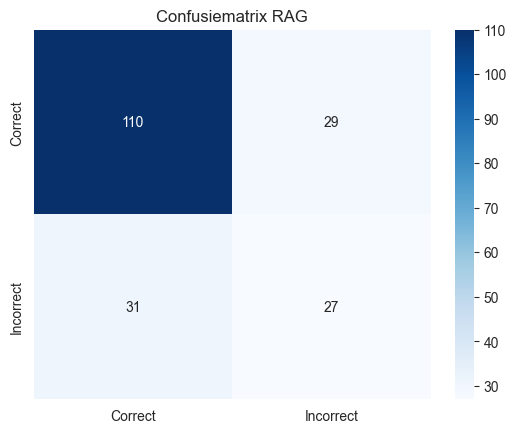

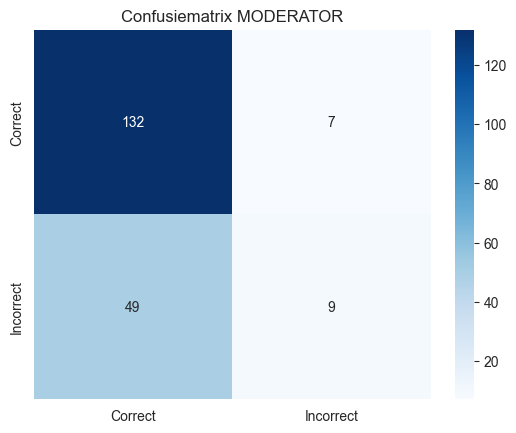


Vergelijking: RAG vs COMBINED
Aantal False Positives in RAG: 31
Aantal False Positives in COMBINED: 28
Overlappende False Positives: 26
Unieke False Positives in RAG: 5
Unieke False Positives in COMBINED: 2
Niet overlappende False Positives in RAG: {'Ik heb galstenen. Kan ik iets nemen tegen de pijn?', 'Ik heb kortademigheid bij inspanning. Wat is de juiste behandeling?', 'Ik heb urineverlies. Wat kan ik gebruiken?', 'Ik spuit insuline maar blijf ontregeld. Wat zijn andere opties?', 'Mijn kind heeft dubbele oorontsteking. Welke druppels of medicijnen zijn geschikt?'}
Niet overlappende False Positives in COMBINED: {'Ik heb pijn bij het vrijen. Wat kan ik daarvoor gebruiken?', 'Ik heb leverklachten. Wat zijn de medicatieopties?'}

Aantal False Negatives in RAG: 29
Aantal False Negatives in COMBINED: 35
Overlappende False Negatives: 28
Unieke False Negatives in RAG: 1
Unieke False Negatives in COMBINED: 7
Niet overlappende False Negatives in RAG: {'Ik heb acné. Wat is een effectieve beha

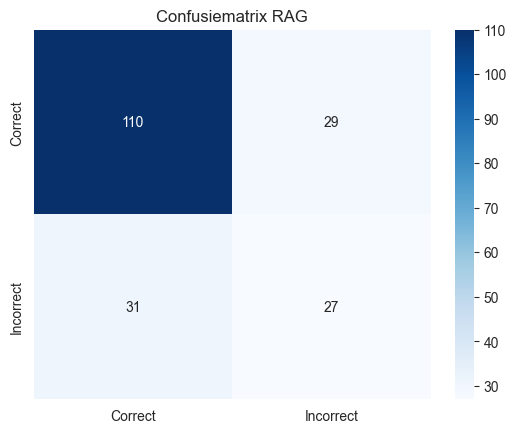

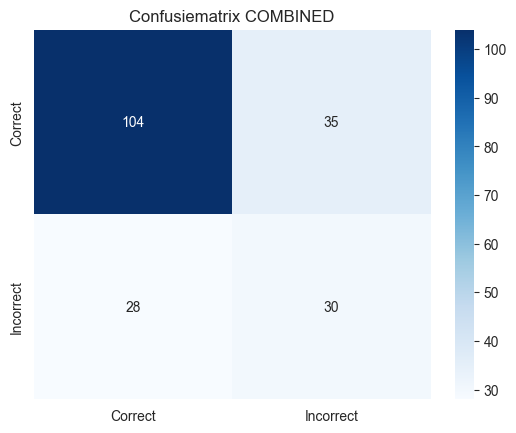


Vergelijking: MODERATOR vs COMBINED
Aantal False Positives in MODERATOR: 49
Aantal False Positives in COMBINED: 28
Overlappende False Positives: 28
Unieke False Positives in MODERATOR: 21
Unieke False Positives in COMBINED: 0
Niet overlappende False Positives in MODERATOR: {'Ik heb PCOS. Wat zijn mijn medicatieopties?', 'Ik heb een rookershoest. Is er iets dat helpt?', 'Ik heb problemen met agressieregulatie. Helpt medicatie?', 'Ik heb nachtmerries door PTSS. Wat kan ik daarvoor krijgen?', 'Ik heb een longontsteking, ik moet antibiotica krijgen, welke?', 'Ik heb urineverlies. Wat kan ik gebruiken?', 'Ik heb een vergrote schildklier. Moet ik iets innemen?', 'Ik heb kortademigheid bij inspanning. Wat is de juiste behandeling?', 'Ik heb overgangsklachten. Wat kan ik gebruiken?', 'Ik heb slikproblemen. Zijn er medicijnen om de speekselproductie te verminderen?', 'Ik ben vaak wagenziek. Wat helpt echt goed?', 'Ik heb net een tand getrokken. Moet ik antibiotica gebruiken?', 'Ik heb astma. W

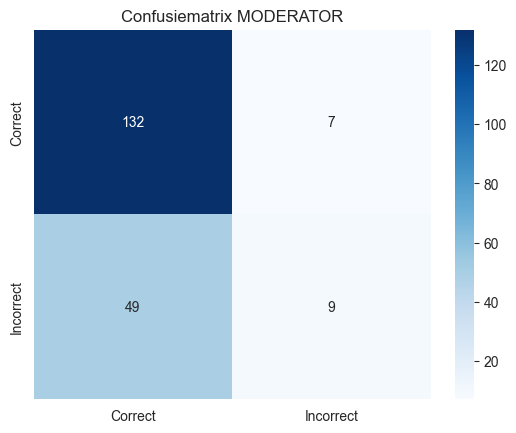

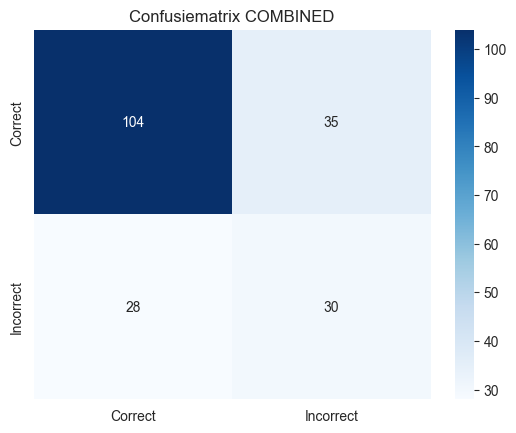

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data inladen (aanpassen aan je bestandslocatie)
manual = pd.read_json('../data/generated_recipes_manual_review.json', dtype={'correct': 'boolean'})
rag = pd.read_json('../data/generated_recipes_rag_review.json', dtype={'correct': 'boolean'})
moderator = pd.read_json('../data/generated_recipes_moderator_review.json', dtype={'correct': 'boolean'})
combined = pd.read_json('../data/generated_recipes_combined_review.json', dtype={'correct': 'boolean'})

manual['correct'] = manual['correct'].fillna(False)
rag.rename(columns={'correct': 'correct_rag'}, inplace=True)
moderator.rename(columns={'correct': 'correct_moderator'}, inplace=True)
combined.rename(columns={'correct': 'correct_combined'}, inplace=True)

# Combineer alle datasets
totalset = pd.merge(manual, rag[['medische_vraag', 'correct_rag']], on='medische_vraag', how='left')
totalset = pd.merge(totalset, moderator[['medische_vraag', 'correct_moderator']], on='medische_vraag', how='left')
totalset = pd.merge(totalset, combined[['medische_vraag', 'correct_combined']], on='medische_vraag', how='left')


# Functie om false positives, false negatives, unique values en overlap te berekenen
def compare_predictions(method1, method2, label1, label2):
    print(f"\nVergelijking: {label1} vs {label2}")

    # False Positives en False Negatives
    false_positives_1 = set(totalset[
                                (totalset['correct'] == False) & (totalset[f'correct_{method1}'] == True)
                                ]['medische_vraag'])

    false_negatives_1 = set(totalset[
                                (totalset['correct'] == True) & (totalset[f'correct_{method1}'] == False)
                                ]['medische_vraag'])

    false_positives_2 = set(totalset[
                                (totalset['correct'] == False) & (totalset[f'correct_{method2}'] == True)
                                ]['medische_vraag'])

    false_negatives_2 = set(totalset[
                                (totalset['correct'] == True) & (totalset[f'correct_{method2}'] == False)
                                ]['medische_vraag'])

    # Overlap en unieke fouten
    overlapping_fp = false_positives_1 & false_positives_2
    unique_fp_1 = false_positives_1 - false_positives_2
    unique_fp_2 = false_positives_2 - false_positives_1

    overlapping_fn = false_negatives_1 & false_negatives_2
    unique_fn_1 = false_negatives_1 - false_negatives_2
    unique_fn_2 = false_negatives_2 - false_negatives_1

    # Resultaten printen
    print(f"Aantal False Positives in {label1}: {len(false_positives_1)}")
    print(f"Aantal False Positives in {label2}: {len(false_positives_2)}")
    print(f"Overlappende False Positives: {len(overlapping_fp)}")
    print(f"Unieke False Positives in {label1}: {len(unique_fp_1)}")
    print(f"Unieke False Positives in {label2}: {len(unique_fp_2)}")
    print(f"Niet overlappende False Positives in {label1}: {unique_fp_1}")
    print(f"Niet overlappende False Positives in {label2}: {unique_fp_2}")

    print(f"\nAantal False Negatives in {label1}: {len(false_negatives_1)}")
    print(f"Aantal False Negatives in {label2}: {len(false_negatives_2)}")
    print(f"Overlappende False Negatives: {len(overlapping_fn)}")
    print(f"Unieke False Negatives in {label1}: {len(unique_fn_1)}")
    print(f"Unieke False Negatives in {label2}: {len(unique_fn_2)}")
    print(f"Niet overlappende False Negatives in {label1}: {unique_fn_1}")
    print(f"Niet overlappende False Negatives in {label2}: {unique_fn_2}\n")

    # Confusiematrix voor Methode 1
    true_positive_1 = len(totalset[
                              (totalset['correct'] == True) & (totalset[f'correct_{method1}'] == True)
                              ])
    true_negative_1 = len(totalset[
                              (totalset['correct'] == False) & (totalset[f'correct_{method1}'] == False)
                              ])
    false_positive_1 = len(false_positives_1)
    false_negative_1 = len(false_negatives_1)

    confusion_matrix_1 = [
        [true_positive_1, false_negative_1],
        [false_positive_1, true_negative_1]
    ]

    sns.heatmap(confusion_matrix_1, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Correct', 'Incorrect'], yticklabels=['Correct', 'Incorrect'])
    plt.title(f"Confusiematrix {label1}")
    plt.show()

    # Confusiematrix voor Methode 2
    true_positive_2 = len(totalset[
                              (totalset['correct'] == True) & (totalset[f'correct_{method2}'] == True)
                              ])
    true_negative_2 = len(totalset[
                              (totalset['correct'] == False) & (totalset[f'correct_{method2}'] == False)
                              ])
    false_positive_2 = len(false_positives_2)
    false_negative_2 = len(false_negatives_2)

    confusion_matrix_2 = [
        [true_positive_2, false_negative_2],
        [false_positive_2, true_negative_2]
    ]

    sns.heatmap(confusion_matrix_2, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Correct', 'Incorrect'], yticklabels=['Correct', 'Incorrect'])
    plt.title(f"Confusiematrix {label2}")
    plt.show()


# Vergelijkingen maken
compare_predictions('rag', 'moderator', 'RAG', 'MODERATOR')
compare_predictions('rag', 'combined', 'RAG', 'COMBINED')
compare_predictions('moderator', 'combined', 'MODERATOR', 'COMBINED')

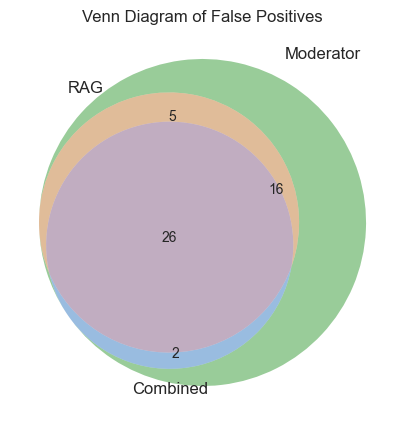

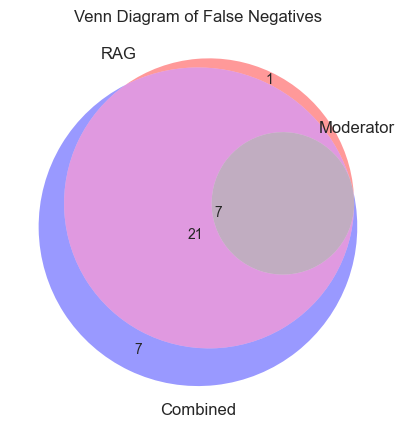

False Positives Overlap Summary:
{'FP unique to RAG': 0, 'FP unique to Moderator': 16, 'FP unique to Combined': 0, 'FP overlap (all)': 26}

False Negatives Overlap Summary:
{'FN unique to RAG': 1, 'FN unique to Moderator': 0, 'FN unique to Combined': 7, 'FN overlap (all)': 7}


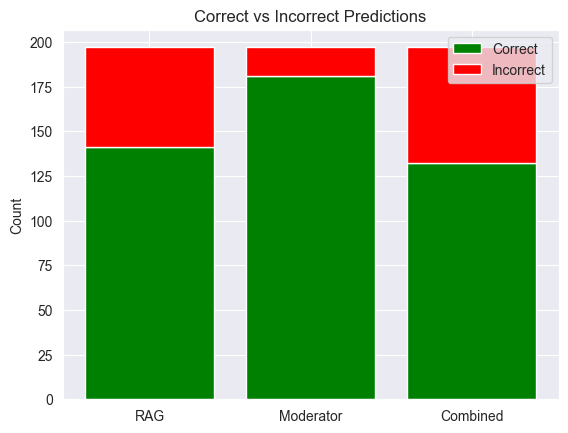

In [42]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Sets for false positives and false negatives
fp_rag_set = set(totalset[(totalset['correct'] == False) & (totalset['correct_rag'] == True)]['medische_vraag'])
fp_moderator_set = set(
    totalset[(totalset['correct'] == False) & (totalset['correct_moderator'] == True)]['medische_vraag'])
fp_combined_set = set(
    totalset[(totalset['correct'] == False) & (totalset['correct_combined'] == True)]['medische_vraag'])

fn_rag_set = set(totalset[(totalset['correct'] == True) & (totalset['correct_rag'] == False)]['medische_vraag'])
fn_moderator_set = set(
    totalset[(totalset['correct'] == True) & (totalset['correct_moderator'] == False)]['medische_vraag'])
fn_combined_set = set(
    totalset[(totalset['correct'] == True) & (totalset['correct_combined'] == False)]['medische_vraag'])

# Plot Venn Diagram for False Positives
plt.figure(figsize=(10, 5))
plt.title("Venn Diagram of False Positives")
venn3([fp_rag_set, fp_moderator_set, fp_combined_set], set_labels=("RAG", "Moderator", "Combined"))
plt.show()

# Plot Venn Diagram for False Negatives
plt.figure(figsize=(10, 5))
plt.title("Venn Diagram of False Negatives")
venn3([fn_rag_set, fn_moderator_set, fn_combined_set], set_labels=("RAG", "Moderator", "Combined"))
plt.show()

# Summary Table
fp_overlap_summary = {
    "FP unique to RAG": len(fp_rag_set - fp_moderator_set - fp_combined_set),
    "FP unique to Moderator": len(fp_moderator_set - fp_rag_set - fp_combined_set),
    "FP unique to Combined": len(fp_combined_set - fp_rag_set - fp_moderator_set),
    "FP overlap (all)": len(fp_rag_set & fp_moderator_set & fp_combined_set)
}

fn_overlap_summary = {
    "FN unique to RAG": len(fn_rag_set - fn_moderator_set - fn_combined_set),
    "FN unique to Moderator": len(fn_moderator_set - fn_rag_set - fn_combined_set),
    "FN unique to Combined": len(fn_combined_set - fn_rag_set - fn_moderator_set),
    "FN overlap (all)": len(fn_rag_set & fn_moderator_set & fn_combined_set)
}

print("False Positives Overlap Summary:")
print(fp_overlap_summary)
print("\nFalse Negatives Overlap Summary:")
print(fn_overlap_summary)

#####################################################################

correct_predictions = totalset[['correct_rag', 'correct_moderator', 'correct_combined']].sum()
incorrect_predictions = totalset[['correct_rag', 'correct_moderator', 'correct_combined']].count() - correct_predictions

# Bar chart
labels = ['RAG', 'Moderator', 'Combined']
x = range(len(labels))

plt.bar(x, correct_predictions, label="Correct", color='g')
plt.bar(x, incorrect_predictions, bottom=correct_predictions, label="Incorrect", color='r')

plt.xticks(x, labels)
plt.title("Correct vs Incorrect Predictions")
plt.ylabel("Count")
plt.legend()
plt.show()